In [2]:
import pandas as pd 
import numpy as np 
import os 
from sklearn.linear_model import LogisticRegression, RidgeClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns 

import swat 
from sasctl import Session
from sasctl.services import model_management as mm 
from sasctl.services import model_repository as mr 
import config
from config import config
import pickle 

from azureml.core import Workspace
from azureml.core import Environment
from azureml.core.model import Model 
from azureml.core.resource_configuration import ResourceConfiguration

## Data prep/EDA

In [3]:
# load in our data 
df = pd.read_csv('http://support.sas.com/documentation/onlinedoc/viya/exampledatasets/hmeq.csv', sep = ',') 

In [4]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [5]:
# replace NA's 
df = df.fillna(df.mean())

In [6]:
# pull out our categorical variables - we don't need them 
df = df.drop(columns=['REASON', 'JOB'], axis = 0)

In [7]:
# split into x and y variables 
x = df.iloc[:, 1:]
y = df.iloc[:, :1]

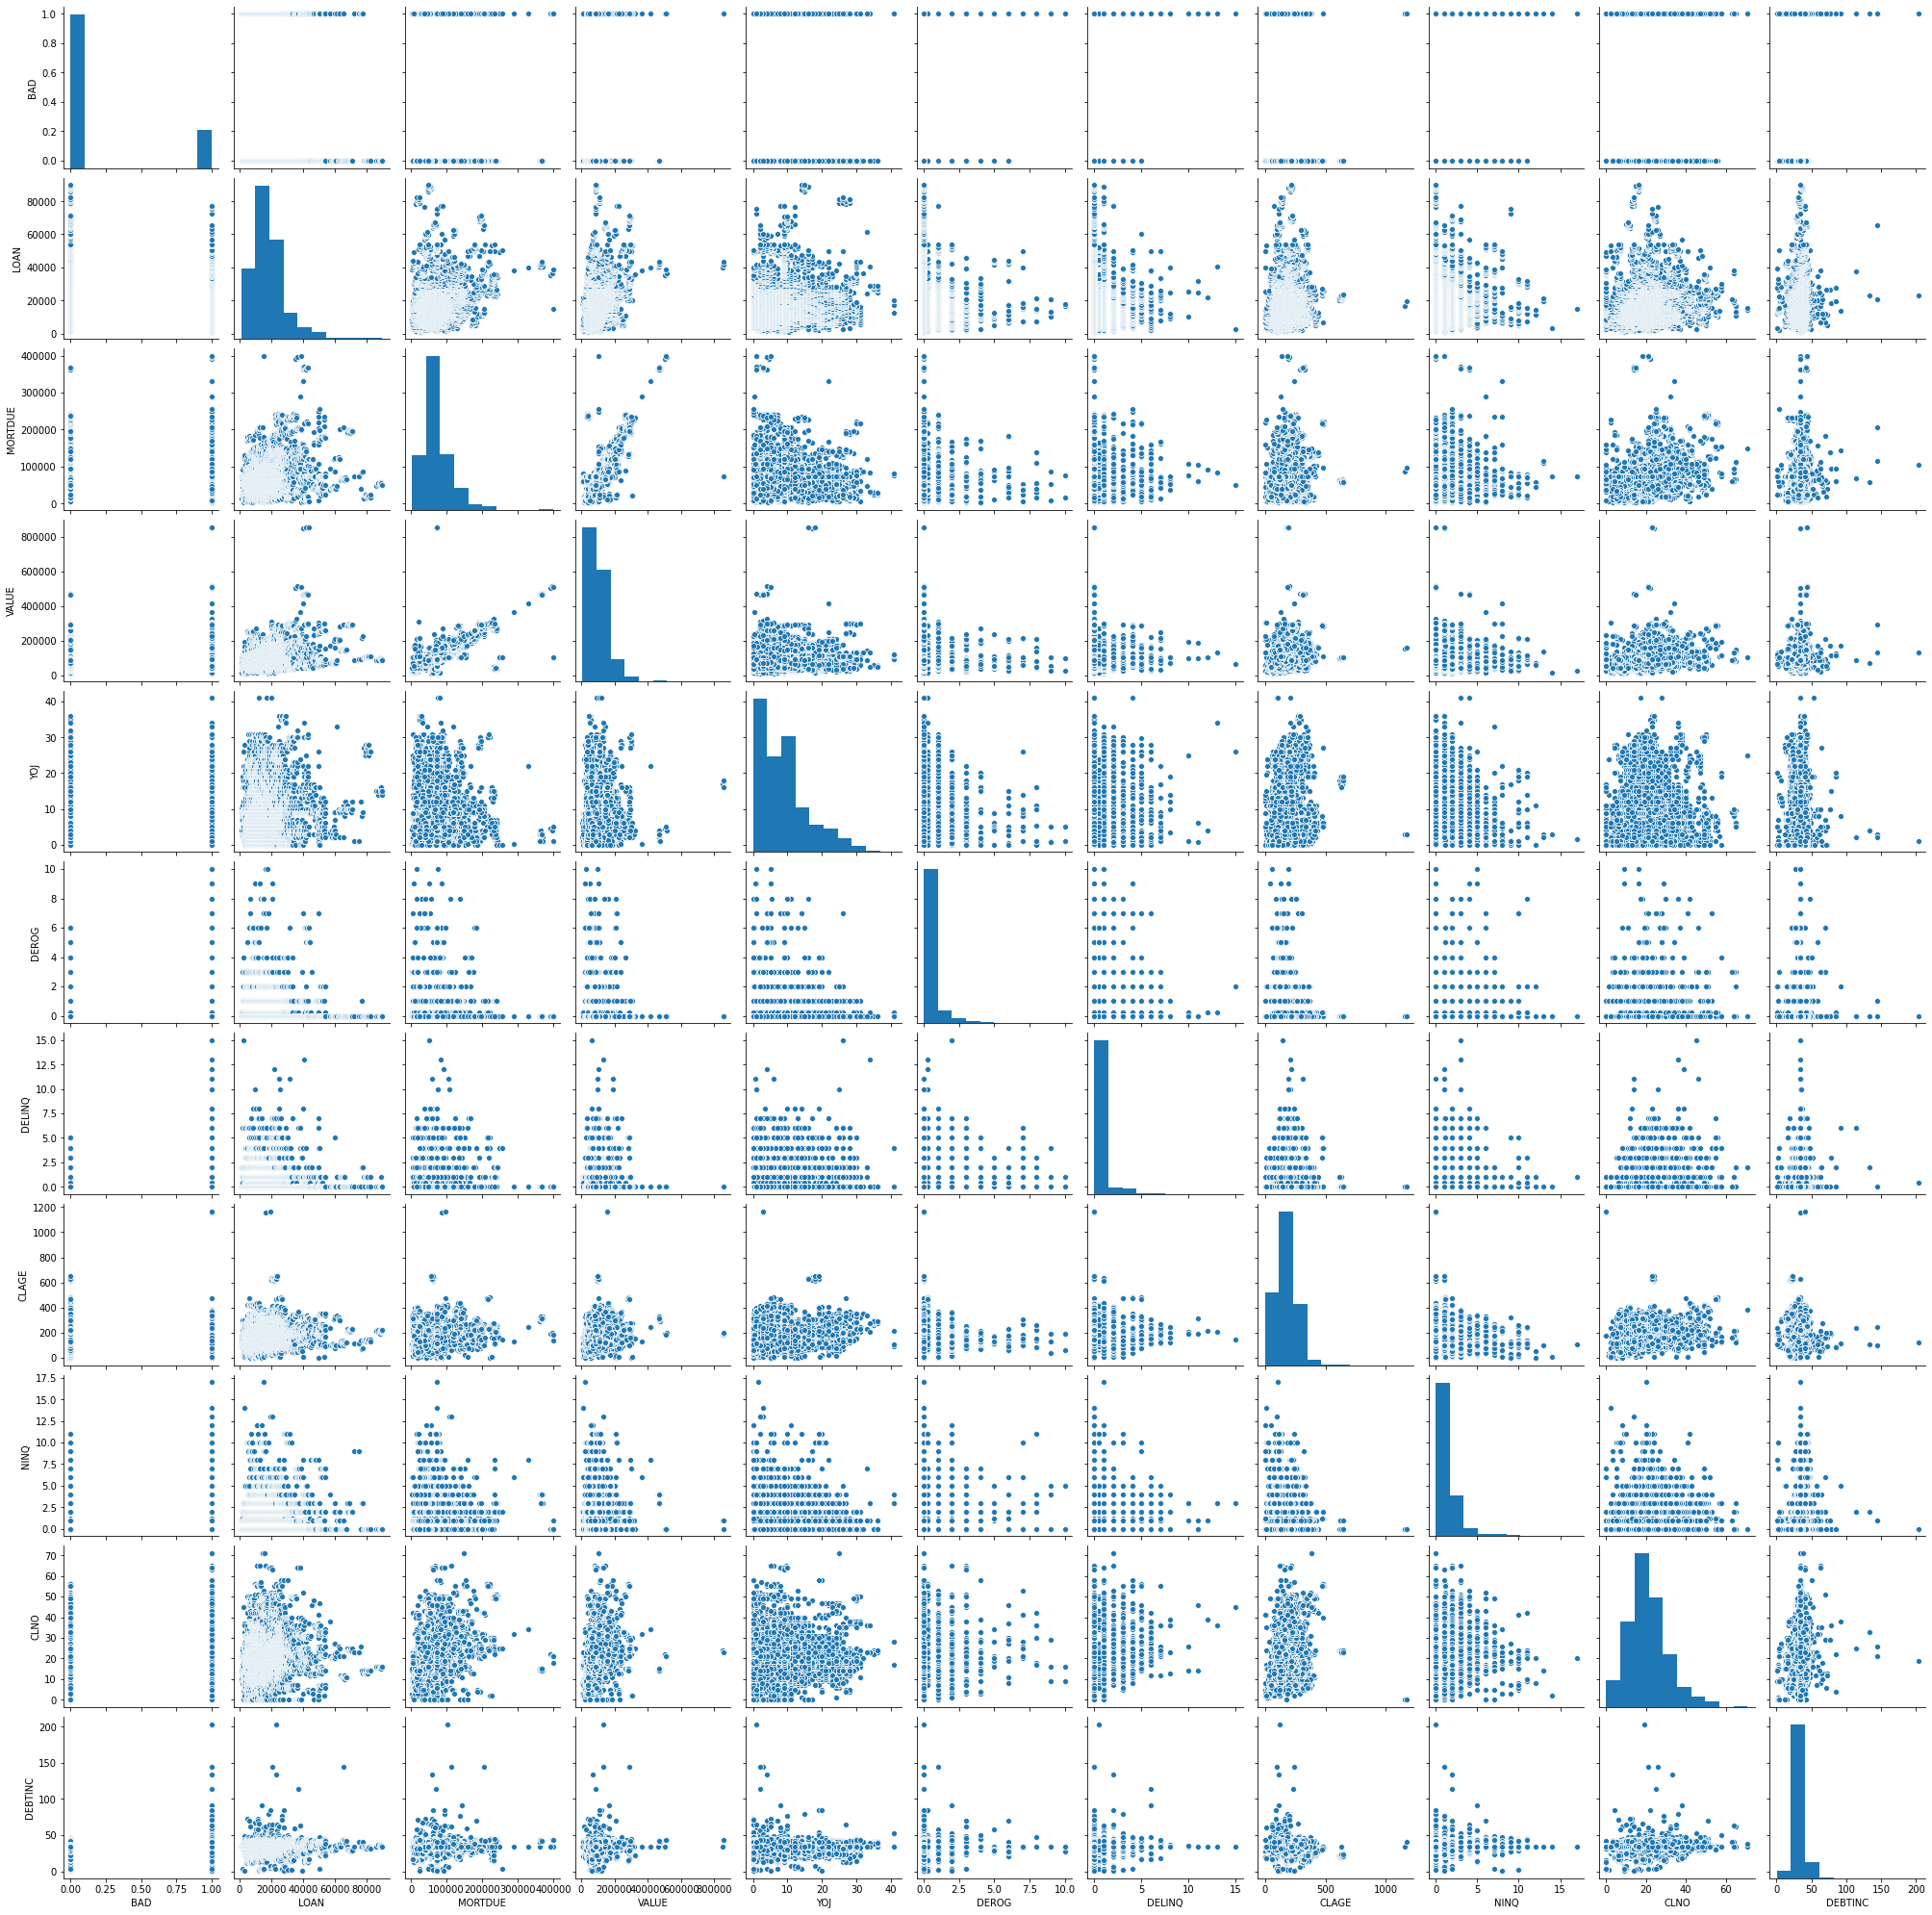

In [11]:
# do we need to transform any variables? - looks alright from this 
sns.pairplot(df)

In [8]:
# train test split our data 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state=808)

## Create Some Models

In [9]:
# create our decision tree model 
dec_tree = DecisionTreeClassifier()

In [10]:
# fit our decision tree model for evaluation purposes 
tree_fit = dec_tree.fit(X_train, y_train)

In [11]:
# evaluate our decision tree model 
y_pred = tree_fit.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[883  63]
 [ 80 166]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       946
           1       0.72      0.67      0.70       246

    accuracy                           0.88      1192
   macro avg       0.82      0.80      0.81      1192
weighted avg       0.88      0.88      0.88      1192



In [12]:
# pickle our model 
# if we want it stored somewhere besides the cwd
#os.chdir("../sklearn_artifacts/")
mod_name = "hmeq_dt.pickle"
pickle.dump(dec_tree, open(mod_name, 'wb'))

In [13]:
# create a ridge logistic regression model 
ridge_log = RidgeClassifier()

In [14]:
ridge_fit = ridge_log.fit(X_train, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [15]:
y_pred = ridge_fit.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[930  16]
 [192  54]]
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       946
           1       0.77      0.22      0.34       246

    accuracy                           0.83      1192
   macro avg       0.80      0.60      0.62      1192
weighted avg       0.82      0.83      0.78      1192



In [16]:
# pickle our model 
mod_name = "hmeq_ridge.pickle"
pickle.dump(ridge_log, open(mod_name, 'wb'))

In [17]:
# try a logistic regression model 
log_reg = LogisticRegression()

In [18]:
log_fit = log_reg.fit(X_train, y_train)

/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
y_pred = log_fit.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[939   7]
 [238   8]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.88       946
           1       0.53      0.03      0.06       246

    accuracy                           0.79      1192
   macro avg       0.67      0.51      0.47      1192
weighted avg       0.74      0.79      0.71      1192



In [20]:
mod_name = "hmeq_log.pickle"
pickle.dump(log_reg, open(mod_name, 'wb'))

## Connect to SAS Model Manager to Register & Deploy the Model 

In [30]:
# set variables for us to use to connect to sas 
host = config.hostname
u = config.username
p = config.password

In [ ]:
# set path to where trustedcerts.pem is located 
os.chdir("/Users/jabras/model_ops/mmgr/Microsoft_roadshow/")
os.environ['CAS_CLIENT_SSL_CA_LIST'] = "./trustedcerts.pem"

In [ ]:
# start our session for registering our models 
Session(host, u, p, verify_ssl=False, protocol='http')

In [ ]:
# create our project for our models 
mr.create_project(
    project = config.project_name,
    repository = 'Public',
    targetLevel = 'Binary',
    function = config.function)

In [ ]:
# create our model 
model_repository.create_model(model = 'nb_dt',
                             project = project_name,
                             description = 'Sklearn decision tree model for hmeq dataset',
                             modeler = config.modeler,
                             algorithm = config.algorithm,
                             tool = config.tool,
                             score_code_type='Python',
                             function= config.function,
                             is_champion=True)

In [36]:
# set path to where we have our model artifacts at
os.chdir("/Users/jabras/model_ops/mmgr/Microsoft_roadshow/sklearn_artifacts/")
#path = Path.cwd()

In [ ]:
filenames = {'file':['inputVar.json','outputVar.json','score_hmeq_dt.py','train_hmeq_dt.py','hmeq_dt.pickle', 'ModelProperties.json', 'fileMetadata.json', 'requirements.txt'],
            'role':['input','output', 'score', 'training', 'score resource', 'model properties', 'file metadata', 'requirements']}

In [ ]:
 for i in range(len(filenames['file'])):

    with open(path / filenames['file'][i], "rb") as _file:

        model_repository.add_model_content(
                      model = config.model_name, 
                      file = _file, 
                      name = filenames['file'][i], 
                      role= filenames['role'][i], 
                      content_type=None)
        
        print('uploaded ' + filenames['file'][i] + ' as ' + filenames['role'][i])
        _file.close()

In [39]:
# publish our model to mas local 
publish_model(config.model_name, 'localhost')

## Register our Trained Model to Azureml

In [ ]:
# create an experiment also? 

In [ ]:
 
ws = Workspace.from_config(".azureml")

myenv = Environment(".azureml/sas-env.yaml")

# if we want to add more features...  
myenv.docker.enabled = True

try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           min_nodes=1,
                                                           max_nodes=4, 
                                                           idle_seconds_before_scaledown=2400)
    cluster = ComputeTarget.create(ws, cluster_name, compute_config)

cluster.wait_for_completion(show_output=True, min_node_count=1, timeout_in_minutes=20)

In [ ]:
# configure and run 
src = ScriptRunConfig(source_directory='.',
                      script = 'model.py',
                      compute_target=cluster, 
                      environment = myenv)
run = experiment.submit(config=src)
run

In [ ]:
# register our model in azureml now 
model = Model.register(workspace = ws,
                       model_name = "log_sklearn",
                       model_path = "hmeq_log.pickle",
                       tags = {'area': 'Home Equity', 'type': 'Tree'})